In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os
import itertools

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

import time

%matplotlib inline

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']


2450083.5


In [3]:
sorce = Table.read("./SORCE/sorce_L3_combined_c24h_20030225_20200225.txt", format="ascii.no_header", guess=False, fast_reader=False, comment=";", data_start=0)

In [4]:
print(sorce)

   col1       col2     col3    col4  col5 col6     col7        col8     col9 
---------- --------- ------- ------- ---- ---- ------------ ---------- ------
20030225.5 2452696.0     0.0     1.0   57   12 1.315986e-06   0.074467    0.0
20030225.5 2452696.0     1.0     2.0   57   12 4.265072e-05   0.074467    0.0
20030225.5 2452696.0     2.0     3.0   57   12  4.07242e-05   0.074467    0.0
20030225.5 2452696.0     3.0     4.0   57   12 3.418736e-05   0.074467    0.0
20030225.5 2452696.0     4.0     5.0   57   12 3.996532e-05   0.074467    0.0
20030225.5 2452696.0     5.0     6.0   57   12 5.403339e-05   0.074467    0.0
20030225.5 2452696.0     6.0     7.0   57   12 6.715881e-05   0.074467    0.0
20030225.5 2452696.0     7.0     8.0   57   12 5.345153e-05   0.074467    0.0
20030225.5 2452696.0     8.0     9.0   57   12 4.856349e-05   0.074467    0.0
20030225.5 2452696.0     9.0    10.0   57   12 3.867245e-05   0.074467    0.0
20030225.5 2452696.0    10.0    11.0   57   12 2.807472e-05   0.

In [5]:
sorce.rename_column('col1', 'yyyymmdd')
sorce.rename_column('col2','jd')
sorce.rename_column('col3','min_wavelength')
sorce.rename_column('col4','max_wavelength')
sorce.rename_column('col5','instrument_mode_id')
sorce.rename_column('col6','data_version')  
sorce.rename_column('col7','irradiance')
sorce.rename_column('col8','irradiance_uncertainty') 
sorce.rename_column('col9','quality')
print(sorce)

 yyyymmdd      jd    min_wavelength max_wavelength instrument_mode_id data_version  irradiance  irradiance_uncertainty quality
---------- --------- -------------- -------------- ------------------ ------------ ------------ ---------------------- -------
20030225.5 2452696.0            0.0            1.0                 57           12 1.315986e-06               0.074467     0.0
20030225.5 2452696.0            1.0            2.0                 57           12 4.265072e-05               0.074467     0.0
20030225.5 2452696.0            2.0            3.0                 57           12  4.07242e-05               0.074467     0.0
20030225.5 2452696.0            3.0            4.0                 57           12 3.418736e-05               0.074467     0.0
20030225.5 2452696.0            4.0            5.0                 57           12 3.996532e-05               0.074467     0.0
20030225.5 2452696.0            5.0            6.0                 57           12 5.403339e-05               0

In [6]:
sorce['avg_wavelength'] = (sorce['min_wavelength']+sorce['max_wavelength'])/2.

In [7]:
# the short-wavelength instrument, covering the EIT bands
XPSmask = (sorce['instrument_mode_id'] == 57)
print(len(sorce[XPSmask]))
print(sorce[XPSmask])

print(len(np.unique(sorce['jd'][XPSmask]))/365.) #~16 years of observations
print(np.min(sorce['yyyymmdd'][XPSmask]))        #beginning late february 2003
print(np.max(sorce['yyyymmdd'][XPSmask]))        #ending late february 2020

234720
 yyyymmdd      jd    min_wavelength max_wavelength instrument_mode_id data_version  irradiance  irradiance_uncertainty quality avg_wavelength
---------- --------- -------------- -------------- ------------------ ------------ ------------ ---------------------- ------- --------------
20030225.5 2452696.0            0.0            1.0                 57           12 1.315986e-06               0.074467     0.0            0.5
20030225.5 2452696.0            1.0            2.0                 57           12 4.265072e-05               0.074467     0.0            1.5
20030225.5 2452696.0            2.0            3.0                 57           12  4.07242e-05               0.074467     0.0            2.5
20030225.5 2452696.0            3.0            4.0                 57           12 3.418736e-05               0.074467     0.0            3.5
20030225.5 2452696.0            4.0            5.0                 57           12 3.996532e-05               0.074467     0.0            4.5

0.0064844


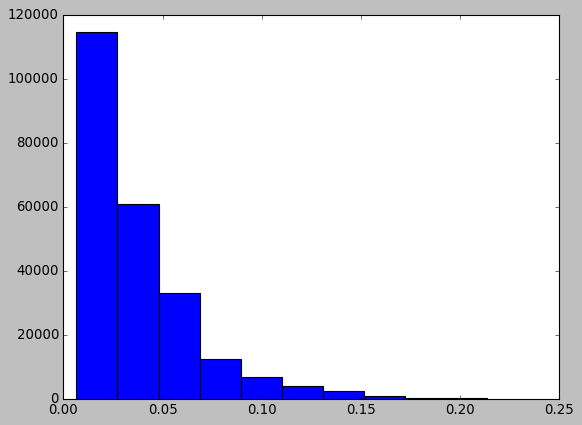

In [8]:
plt.hist(sorce['irradiance_uncertainty'][XPSmask])
print(np.min(sorce['irradiance_uncertainty'][XPSmask]))

In [9]:
mask = (sorce['jd']==2458903.0)
print(len(sorce[mask]))
print(sorce[mask]['min_wavelength','max_wavelength','avg_wavelength'][0:40]) 
#note that these are all in nanometers!

985
min_wavelength max_wavelength avg_wavelength
-------------- -------------- --------------
           0.0            1.0            0.5
           1.0            2.0            1.5
           2.0            3.0            2.5
           3.0            4.0            3.5
           4.0            5.0            4.5
           5.0            6.0            5.5
           6.0            7.0            6.5
           7.0            8.0            7.5
           8.0            9.0            8.5
           9.0           10.0            9.5
          10.0           11.0           10.5
          11.0           12.0           11.5
          12.0           13.0           12.5
          13.0           14.0           13.5
           ...            ...            ...
          26.0           27.0           26.5
          27.0           28.0           27.5
          28.0           29.0           28.5
          29.0           30.0           29.5
          30.0           31.0           30.5
      

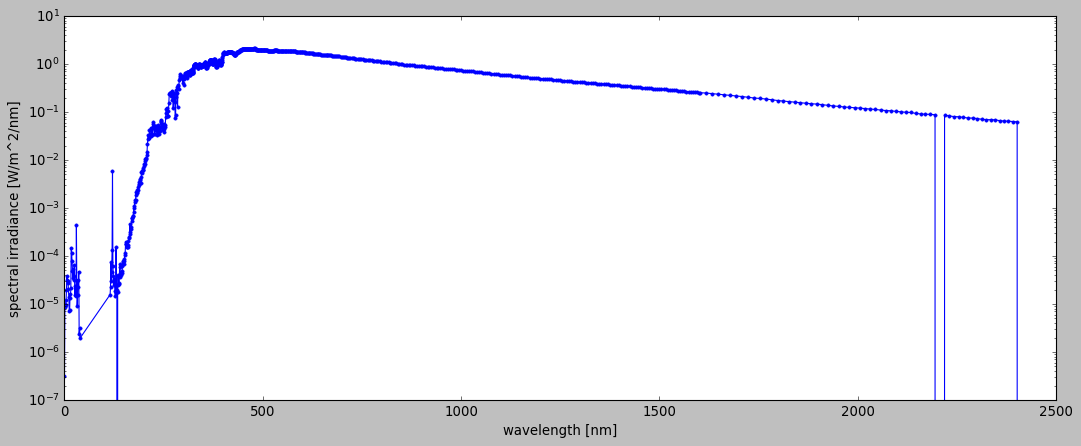

In [10]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
#ax.errorbar(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], yerr=sorce[mask]['irradiance_uncertainty'], marker='.',capsize=0,elinewidth=1, ms=2, alpha=0.5,ls='-')
ax.plot(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], 'b-',marker='.')

ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("spectral irradiance [W/m^2/nm]")
ax.set_yscale("log")
plt.show()

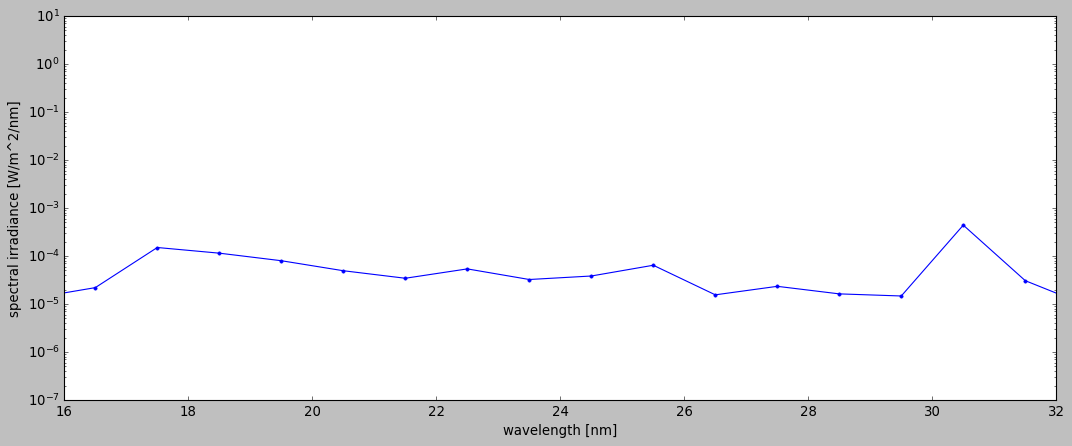

In [11]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
#ax.errorbar(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], yerr=sorce[mask]['irradiance_uncertainty'], marker='.',capsize=0,elinewidth=1, ms=2, alpha=0.5,ls='-')
ax.plot(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], 'b-',marker='.')

ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("spectral irradiance [W/m^2/nm]")
ax.set_yscale("log")
ax.set_xlim(16,32)
plt.show()

In [12]:
# results of digitizing figure 8 of Newmark et al 2000
# note that these are pre-flight calibration curves and do not include detector degradation. Assume that
# the soho pipeline has otherwise accounted for that (for now).
filt171 = np.genfromtxt("./EIT/filterResponse/newmark+2000_fig8_171angstrom_digitized.txt")
filt195 = np.genfromtxt("./EIT/filterResponse/newmark+2000_fig8_195angstrom_digitized.txt")
filt284 = np.genfromtxt("./EIT/filterResponse/newmark+2000_fig8_284angstrom_digitized.txt")
filt304 = np.genfromtxt("./EIT/filterResponse/newmark+2000_fig8_304angstrom_digitized.txt")

In [13]:
def linearlyInterpolateSpectrum(wavelength, flux):
    '''
    linearly interpolate the spectrum to angstrom rather than nm scales
    '''
    interp_wavelength = np.zeros((len(wavelength) - 1)*10, dtype=float)
    interp_flux = np.zeros((len(wavelength) - 1)*10, dtype=float)

    for i in range(len(wavelength) - 1):
        for j in range(10):
            interp_wavelength[(10*i) + j] = wavelength[i] + 0.1*j
            interp_flux[(10*i) + j] = flux[i] + (flux[i+1] - flux[i])*(0.1*j)
    
    return interp_wavelength, interp_flux

[5.0000e-01 6.0000e-01 7.0000e-01 ... 2.4021e+03 2.4022e+03 2.4023e+03]
[3.10627800e-07 1.13403632e-06 1.95744484e-06 ... 1.87405980e-02
 1.24937320e-02 6.24686600e-03]


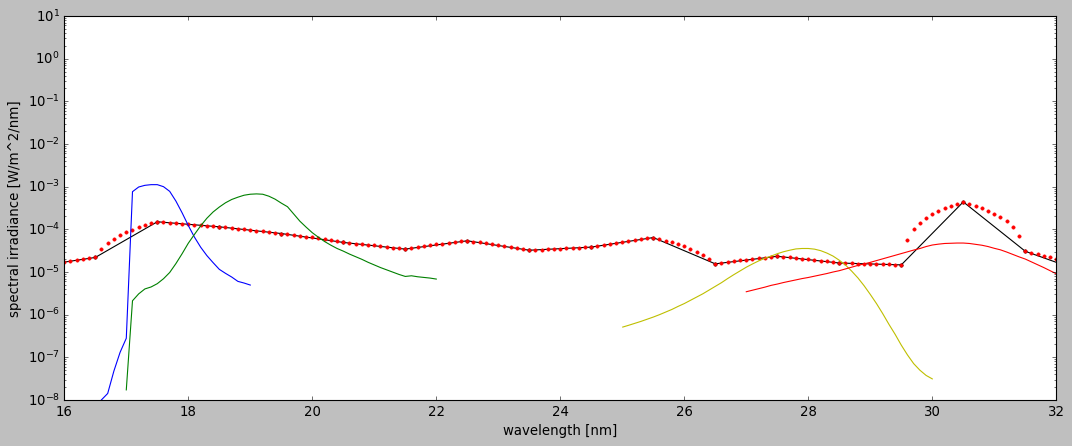

In [14]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
#ax.errorbar(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], yerr=sorce[mask]['irradiance_uncertainty'], marker='.',capsize=0,elinewidth=1, ms=2, alpha=0.5,ls='-')
ax.plot(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'], 'k-',marker='.')

i_w, i_f = linearlyInterpolateSpectrum(sorce[mask]['avg_wavelength'], sorce[mask]['irradiance'])
print(i_w)
print(i_f)
ax.plot(i_w, i_f, 'r.')


ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("spectral irradiance [W/m^2/nm]")
ax.set_xlim(16,32)

ax.plot(filt171[:,0]/10,filt171[:,1]*1.e8,'b-')
ax.plot(filt195[:,0]/10,filt195[:,1]*1.e8,'g-')
ax.plot(filt284[:,0]/10,filt284[:,1]*1.e8,'y-')
ax.plot(filt304[:,0]/10,filt304[:,1]*1.e8,'r-')
ax.set_yscale("log")
#ax.set_ylim(1.e-5, 1.e-4)
plt.show()

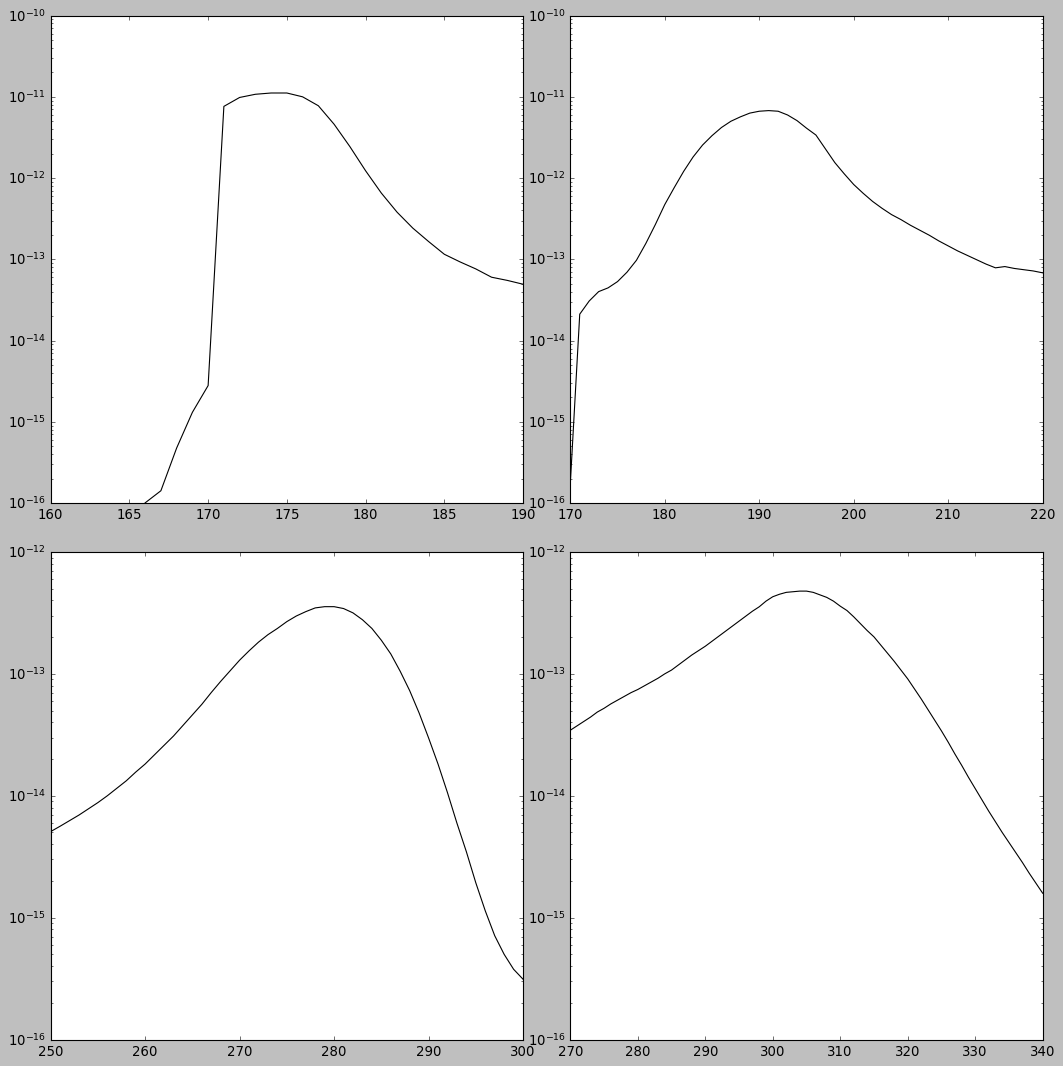

In [15]:
fig, axes = plt.subplots(2,2,figsize=(16,16))
axes[0,0].plot(filt171[:,0],filt171[:,1],'k-')
axes[0,1].plot(filt195[:,0],filt195[:,1],'k-')
axes[1,0].plot(filt284[:,0],filt284[:,1],'k-')
axes[1,1].plot(filt304[:,0],filt304[:,1],'k-')

axes[0,0].set_xlim(160,190)
axes[0,0].set_ylim(1.e-16,1.e-10)
axes[0,1].set_xlim(170,220)
axes[0,1].set_ylim(1.e-16,1.e-10)
axes[1,0].set_xlim(250,300)
axes[1,0].set_ylim(1.e-16,1.e-12)
axes[1,1].set_xlim(270,340)
axes[1,1].set_ylim(1.e-16,1.e-12)
for ax in np.ravel(axes):
    ax.set_yscale("log")
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()

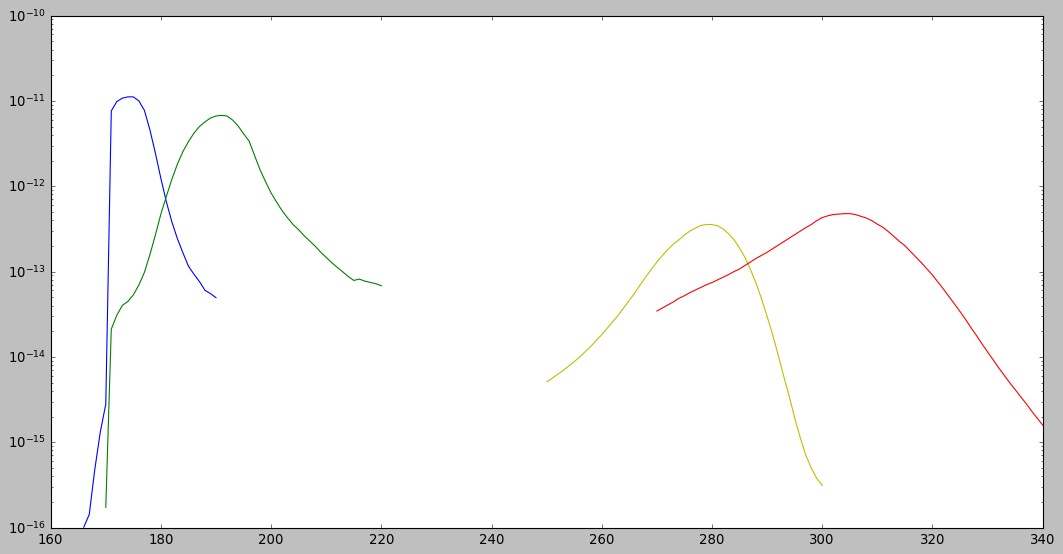

In [16]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(filt171[:,0],filt171[:,1],'b-')
ax.plot(filt195[:,0],filt195[:,1],'g-')
ax.plot(filt284[:,0],filt284[:,1],'y-')
ax.plot(filt304[:,0],filt304[:,1],'r-')
ax.set_yscale("log")
plt.show()